In [125]:
# Define RBF utilities (1D)
import numpy as np

def rbf_kernel(radius: np.ndarray, eps: float):
    return np.exp(-eps ** 2 * radius ** 2)

def get_rbf_matrix(interpolation_points: np.ndarray, centers: np.ndarray, eps: float = 0.1) -> np.ndarray:
    rbf_matrix = np.zeros(shape = (centers.shape[0], centers.shape[0]))
    for row_index in range(centers.shape[0]):
        rbf_matrix[row_index, :] = rbf_kernel(radius = np.abs(interpolation_points[row_index] - centers),
                                                 eps = eps)
    return rbf_matrix

from typing import Callable
def get_rbf_interpolant(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    coefficients = np.linalg.solve(matrix, interpolation_targets)
    print(coefficients)
    # coefficients = np.matmul(np.linalg.inv(matrix), interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_kernel(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

In [126]:
import torch

N = 5
x = torch.linspace(0, 2, N)
y = torch.exp(x)
degree = 2

In [127]:
# This matrix is P^T
poly_matrix_centers = torch.zeros(size=(degree + 1, N))
for i in range(degree + 1):
    poly_matrix_centers[i, :] = torch.pow(x, i)

In [128]:
A = torch.from_numpy(get_rbf_matrix(x, x, 0.5))
P_T = poly_matrix_centers

In [129]:
Interpolation_Problem_Matrix = torch.zeros(size=(N + degree + 1, N + degree + 1))
Interpolation_Problem_Matrix[0:5, 0:5] = A
Interpolation_Problem_Matrix[0:5, 5:8] = P_T.t()
Interpolation_Problem_Matrix[5:8, 0:5] = P_T
Interpolation_Problem_Matrix

tensor([[1.0000, 0.9394, 0.7788, 0.5698, 0.3679, 1.0000, 0.0000, 0.0000],
        [0.9394, 1.0000, 0.9394, 0.7788, 0.5698, 1.0000, 0.5000, 0.2500],
        [0.7788, 0.9394, 1.0000, 0.9394, 0.7788, 1.0000, 1.0000, 1.0000],
        [0.5698, 0.7788, 0.9394, 1.0000, 0.9394, 1.0000, 1.5000, 2.2500],
        [0.3679, 0.5698, 0.7788, 0.9394, 1.0000, 1.0000, 2.0000, 4.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 1.0000, 2.2500, 4.0000, 0.0000, 0.0000, 0.0000]])

In [130]:
net_params = torch.linalg.solve(Interpolation_Problem_Matrix, torch.cat((y, torch.zeros(3))).t())
net_params

tensor([ 5.2748e-01, -2.0943e+01,  5.9663e+01, -5.8608e+01,  1.9360e+01,
        -4.7656e-02,  4.8728e-01,  1.8581e+00])

In [131]:
net_params_rbf = torch.linalg.solve(A, y.double())
net_params_rbf

tensor([ 151.1471, -567.4400,  911.9290, -745.9235,  265.6221],
       dtype=torch.float64)

In [180]:
import sys
sys.path.insert(0, '..')

import nn_rbf

rbf_interpolant = nn_rbf.PolynomialRBFInterpolant(centers=x, eps=0.5, 
    alphas=(net_params[:-3]).numpy(), 
    coefficients=(net_params[-3:]).numpy(), degree=2)

torch.mean((rbf_interpolant(x) - y) ** 2) # MSE

tensor(1.7522e-11, grad_fn=<MeanBackward0>)

In [185]:
it = 1
save_every = 50000
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rbf_interpolant.parameters(), lr=1e-4)
while it < save_every:
    output = loss(rbf_interpolant(x), y)
    print(f'{it}: {output}',end='\r')

    if output < 1e-13:
        print(output)
        break

    output.backward()
    optimizer.step()
    optimizer.zero_grad()
    it = it + 1
    

tensor(9.3792e-14, grad_fn=<MseLossBackward0>)


In [186]:
print(rbf_interpolant.coefficients)
print(rbf_interpolant.alphas)

Parameter containing:
tensor([-0.0477,  0.4873,  1.8580], requires_grad=True)
Parameter containing:
tensor([  0.5276, -20.9428,  59.6634, -58.6085,  19.3604], requires_grad=True)


In [188]:
rbf_optimized_alphas = [0.1771955,3.0072856,2.5823133,-0.24359791,-4.364153]
rbf_optimized_coefs = [-2.2691066,0.9085923,2.1610441]
rbf_alternative = nn_rbf.PolynomialRBFInterpolant(
    centers=x, eps=0.5, alphas=rbf_optimized_alphas, coefficients=rbf_optimized_coefs, degree=2)

In [190]:
print(loss(rbf_interpolant(x), y))
print(loss(rbf_alternative(x), y))

tensor(9.3792e-14, grad_fn=<MseLossBackward0>)
tensor(0., grad_fn=<MseLossBackward0>)


Comparison

In [208]:
x_v = torch.linspace(0, 2, 10000)
y_v = torch.exp(x_v)

rbf_interpolant_untrained = nn_rbf.PolynomialRBFInterpolant(centers=x, eps=0.5, 
    alphas=[5.2748e-01, -2.0943e+01,  5.9663e+01, -5.8608e+01,  1.9360e+01], 
    coefficients=[-4.7656e-02,  4.8728e-01,  1.8581e+00], degree=2)

    
results_matrix = torch.abs(rbf_interpolant(x_v) - y_v)
results_alt = torch.abs(rbf_alternative(x_v) - y_v)
results_untrained = torch.abs(rbf_interpolant_untrained(x_v) - y_v)

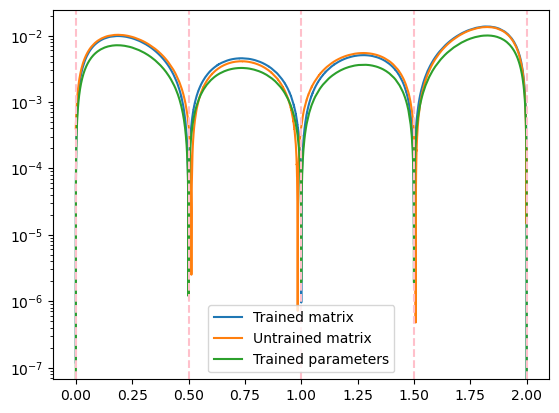

In [211]:
import matplotlib.pyplot as plt

plt.semilogy(x_v, results_matrix.detach(), label = 'Trained matrix')
plt.semilogy(x_v, results_untrained.detach(), label = 'Untrained matrix')
plt.semilogy(x_v, results_alt.detach(), label = 'Trained parameters')

for x_h in x:
    plt.axvline(x_h, linestyle='--', color='pink')

plt.legend()